In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd
%cd /content/gdrive/My Drive/WorldModelsExperiments/carracing
!pwd

/content
/content/gdrive/My Drive/WorldModelsExperiments/carracing
/content/gdrive/My Drive/WorldModelsExperiments/carracing


In [ ]:
!pip install Box2D
!apt-get update
!apt-get install -y xvfb #python-opengl
!pip install pyvirtualdisplay
!pip install gym==0.9.4
!pip install pyglet==1.3.2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://archive.ubuntu.com/ubu

In [ ]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [ ]:
%tensorflow_version 1.8.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.8.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
!pip show pyglet

Name: pyglet
Version: 1.3.2
Summary: Cross-platform windowing and multimedia library
Home-page: http://pyglet.readthedocs.org/en/latest/
Author: Alex Holkner
Author-email: Alex.Holkner@gmail.com
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: future
Required-by: gym


In [ ]:
import numpy as np
import random
import os
import gym

In [ ]:
'''
saves ~ 200 episodes generated from a random policy
'''

# import numpy as np
# import random
# import os
# import gym

from model import make_model

MAX_FRAMES = 1000 # max length of carracing
MAX_TRIALS = 200 # just use this to extract one trial.

render_mode = False # for debugging.

DIR_NAME = '/content/gdrive/My Drive/WorldModelsExperiments/carracing/Data'
if not os.path.exists(DIR_NAME):
    os.makedirs(DIR_NAME)

model = make_model(load_model=False)

total_frames = 0
model.make_env(render_mode=render_mode, full_episode=True)
for trial in range(MAX_TRIALS): # 200 trials per worker
  try:
    random_generated_int = random.randint(0, 2**31-1)
    filename = DIR_NAME+"/"+str(random_generated_int)+".npz"
    recording_obs = []
    recording_action = []

    np.random.seed(random_generated_int)
    model.env.seed(random_generated_int)

    # random policy
    model.init_random_model_params(stdev=np.random.rand()*0.01)

    model.reset()
    obs = model.env.reset() # pixels

    for frame in range(MAX_FRAMES):
      if render_mode:
        model.env.render("human")
      else:
        model.env.render("rgb_array")

      recording_obs.append(obs)

      z, mu, logvar = model.encode_obs(obs)
      action = model.get_action(z)

      recording_action.append(action)
      obs, reward, done, info = model.env.step(action)

      if done:
        break

    total_frames += (frame+1)
    print("dead at", frame+1, "total recorded frames for this worker", total_frames)
    recording_obs = np.array(recording_obs, dtype=np.uint8)
    recording_action = np.array(recording_action, dtype=np.float16)
    np.savez_compressed(filename, obs=recording_obs, action=recording_action)
  except gym.error.Error:
    print("stupid gym error, life goes on")
    model.env.close()
    model.make_env(render_mode=render_mode)
    continue
model.env.close()




INFO:tensorflow:Model using cpu.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.





KeyboardInterrupt: ignored

In [ ]:
'''
Train VAE model on data created using extract.py
final model saved into tf_vae/vae.json
'''

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # can just override for multi-gpu systems

import tensorflow as tf
import random
import numpy as np
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

from vae.vae import ConvVAE, reset_graph

# Hyperparameters for ConvVAE
z_size=32
batch_size=100
learning_rate=0.0001
kl_tolerance=0.5

# Parameters for training
NUM_EPOCH = 2
DATA_DIR = "/content/gdrive/My Drive/WorldModelsExperiments/carracing/Data"

model_save_path = "/content/gdrive/My Drive/WorldModelsExperiments/carracing/vae"
if not os.path.exists(model_save_path):
  os.makedirs(model_save_path)

def count_length_of_filelist(filelist):
  # although this is inefficient, much faster than doing np.concatenate([giant list of blobs])..
  N = len(filelist)
  total_length = 0
  for i in range(N):
    filename = filelist[i]
    raw_data = np.load(os.path.join(DATA_DIR, filename))['obs']
    l = len(raw_data)
    total_length += l
    if (i % 1000 == 0):
      print("loading file", i)
  return  total_length

def create_dataset(filelist, N=10000, M=1000): # N is 10000 episodes, M is number of timesteps
  data = np.zeros((M*N, 64, 64, 3), dtype=np.uint8)
  idx = 0
  for i in range(N):
    filename = filelist[i]
    raw_data = np.load(os.path.join(DATA_DIR, filename))['obs']
    l = len(raw_data)
    if (idx+l) > (M*N):
      data = data[0:idx]
      print('premature break')
      break
    data[idx:idx+l] = raw_data
    idx += l
    if ((i+1) % 100 == 0):
      print("loading file", i+1)
  return data

# load dataset from record/*. only use first 10K, sorted by filename.
filelist = os.listdir(DATA_DIR)
filelist.sort()
filelist = filelist[0:10000]
#print("check total number of images:", count_length_of_filelist(filelist))
dataset = create_dataset(filelist)

# split into batches:
total_length = len(dataset)
num_batches = int(np.floor(total_length/batch_size))
print("num_batches", num_batches)

reset_graph()

vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True)

# train loop:
print("train", "step", "loss", "recon_loss", "kl_loss")
for epoch in range(NUM_EPOCH):
  np.random.shuffle(dataset)
  for idx in range(num_batches):
    batch = dataset[idx*batch_size:(idx+1)*batch_size]

    obs = batch.astype(np.float)/255.0

    feed = {vae.x: obs,}

    (train_loss, r_loss, kl_loss, train_step, _) = vae.sess.run([
      vae.loss, vae.r_loss, vae.kl_loss, vae.global_step, vae.train_op
    ], feed)
  
    if ((train_step+1) % 500 == 0):
      print("step", (train_step+1), train_loss, r_loss, kl_loss)
    if ((train_step+1) % 5000 == 0):
      vae.save_json( model_save_path + "/vae_self_{}.json".format(NUM_EPOCH))

# finished, final model:
vae.save_json(model_save_path + "/vae_self_{}.json".format(NUM_EPOCH))


In [ ]:
data = np.load('/content/gdrive/MyDrive/WorldModelsExperiments/carracing/Data/1007209374.npz')
frames = data['obs']
frames = frames.astype(np.float32)

In [ ]:
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

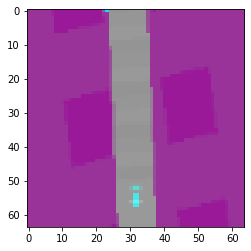

In [ ]:
# show recorded frame that will be fed into the input of VAE
# for i in range(np.shape(frames)[0]):
# import cv2
# from google.colab.patches import cv2_imshow
frame = random.choice(frames).astype(np.uint8)
# np.moveaxis(frame, )
fig = plt.figure('k')
plt.imshow(frame)
# cv2_imshow(frame)
plt.show()
# print(frame)
# from PIL import Image
# im = Image.fromarray(frame)
# im.show()
# print(frame[0,0,:])
fig.savefig('frame.png')

In [ ]:
from vae.vae import ConvVAE, reset_graph

In [ ]:
z_size = 32
model_path_name = '/content/gdrive/My Drive/WorldModelsExperiments/carracing/vae'
vae = ConvVAE(z_size=z_size,
              batch_size=1,
              is_training=False,
              reuse=False,
              gpu_mode=False)

vae.load_json(os.path.join(model_path_name, 'vae.json'))



INFO:tensorflow:Model using cpu.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.





In [ ]:
batch_z = vae.encode(np.expand_dims(frame, 0))
# print(np.shape(frame))
print(batch_z[0]) # print out sampled z
# print(np.shape(batch_z[0]))
reconstruct = vae.decode(batch_z)

[    -7.3798    -28.6069   -198.996     -12.9388    -24.4604    130.9974     -8.7139    -17.5424
     -7.2954   -135.2046     21.5702    -14.2117    -10.8446      8.1322   -102.4489    -93.9528
     14.055     562.8981    295.5195      4.5995    148.3639    355.6322    -13.5248    -48.5271
      6.8703     71.7277     79.3225    -10.0039   -188.2822   -174.3987      8.8268 -10629.584 ]


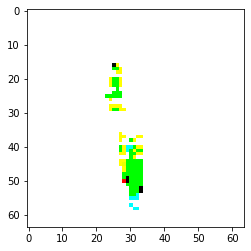

In [ ]:
fig = plt.figure('r')
plt.imshow(reconstruct[0])
plt.show()
fig.savefig('rec.png')

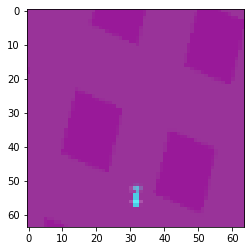

In [3]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os

DATA_DIR = '/content/gdrive/MyDrive/WorldModelsExperiments/carracing/Data'

filelist = os.listdir(DATA_DIR)
filelist.sort()
filelist = filelist[195:]

# print(filelist)

data = np.load(DATA_DIR + '/' + filelist[1])
game_frames = data['obs']
game_frames = game_frames.astype(np.float32)/255.0

# def fr(frames):
#   x = np.shape(frames)[0]
#   i = 0
#   while i <= x:
#     yield frames[i]
#     i += i 


fig = plt.figure('hh')
img = [[plt.imshow(frame)] for frame in game_frames]
# def animate(i):
#   return plt.imshow(i)

# anim = animation.FuncAnimation(fig, animate, fr(game_frames[0:10]), interval = 20, blit = True)
anim = animation.ArtistAnimation(fig, img, interval = 20, blit = True, repeat_delay=0)
anim.save('random_trail.mp4')

# plt.show()